In [88]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.model_selection import train_test_split, GridSearchCV
from sklearn.preprocessing import StandardScaler
from sklearn.metrics import classification_report, roc_auc_score, roc_curve, auc, confusion_matrix
from imblearn.over_sampling import SMOTE
from collections import Counter
import joblib

In [89]:
from sklearn.linear_model import LogisticRegression
from sklearn.ensemble import RandomForestClassifier, GradientBoostingClassifier
from xgboost import XGBClassifier

In [90]:
health_care = pd.read_csv("cleaned_data_2.csv")
health_care_df = pd.DataFrame(health_care)
health_care_df.head()

,gender,age,hypertension,heart_disease,ever_married,work_type,Residence_type,avg_glucose_level,bmi,smoking_status,stroke,age_category,bmi_category,glucose_category
0,0,0.817073,0,1,1,0,0,0.801265,0.745455,0,1,2,3,4
1,1,0.743902,0,0,1,1,1,0.679023,0.487879,1,1,2,2,4
2,0,0.975610,0,1,1,0,1,0.234512,0.621212,1,1,2,3,3
3,1,0.597561,0,0,1,0,0,0.536008,0.678788,2,1,1,3,2
4,1,0.963415,1,0,1,1,1,0.549349,0.363636,1,1,2,1,2


In [91]:
print("Data Shape:", health_care_df.shape)
print("\nMissing Values:", health_care_df.isnull().sum().max())
print("\nClass Distribution:\n", health_care_df['stroke'].value_counts(normalize=True))

Data Shape: (5110, 14)

Missing Values: 0

Class Distribution:
 stroke
0    0.951272
1    0.048728
Name: proportion, dtype: float64


In [92]:
X = health_care_df.drop(['stroke'], axis=1)
y = health_care_df['stroke']

# <span style="color:red">Visualize</span>

In [93]:
class_counts = np.bincount(y)
print(f"Class 0 (Negative): {class_counts[0]} samples")
print(f"Class 1 (Positive): {class_counts[1]} samples")
print(f"Imbalance ratio: 1:{class_counts[0]/class_counts[1]:.2f}")

Class 0 (Negative): 4861 samples
Class 1 (Positive): 249 samples
Imbalance ratio: 1:19.52


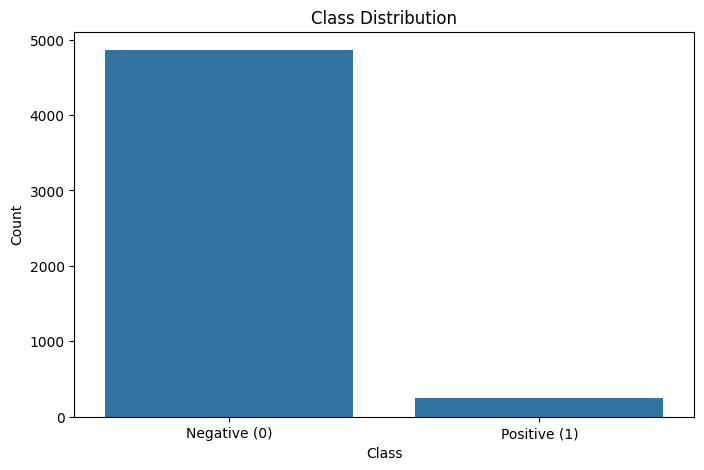

In [94]:
plt.figure(figsize=(8, 5))
sns.countplot(x=y)
plt.title('Class Distribution')
plt.xlabel('Class')
plt.ylabel('Count')
plt.xticks([0, 1], ['Negative (0)', 'Positive (1)'])
plt.show()

# <span style="color:red">Imbalance Dataset</span>
### <span style="color:orange">Ratio of class 1 to class 0 is bad so we will apply oversampling</span>

In [95]:
smote = SMOTE(sampling_strategy=0.7,random_state=42)
X_smote, y_smote = smote.fit_resample(X, y)
print("After SMOTE:", Counter(y_smote))

After SMOTE: Counter({0: 4861, 1: 3402})


In [96]:
X_train, X_test, y_train, y_test = train_test_split(X_smote, y_smote, test_size=0.2, stratify=y_smote, random_state=42)

In [97]:
scaler = StandardScaler()
X_train_scaled = scaler.fit_transform(X_train)
X_test_scaled = scaler.transform(X_test)

print("Class distribution in training:", Counter(y_train))

Class distribution in training: Counter({0: 3889, 1: 2721})


# <span style="color:red">Logistic Regression</span>

In [98]:
lr_model = LogisticRegression(class_weight='balanced')

In [99]:
param_grid = {'C': [0.1, 1, 10]}
grid = GridSearchCV(lr_model, param_grid, cv=5, scoring='roc_auc', n_jobs=-1)
grid.fit(X_train_scaled, y_train)
best_lr_model = grid.best_estimator_
y_pred = best_lr_model.predict(X_test_scaled)
y_proba = best_lr_model.predict_proba(X_test_scaled)[:,1]

In [100]:
print("\nClassification Report For Logistic Regression :")
print(classification_report(y_test, y_pred))
print("\nAUC-ROC For Logistic Regression :", roc_auc_score(y_test, y_proba))


Classification Report For Logistic Regression :
              precision    recall  f1-score   support

           0       0.85      0.78      0.81       972
           1       0.72      0.81      0.76       681

    accuracy                           0.79      1653
   macro avg       0.79      0.79      0.79      1653
weighted avg       0.80      0.79      0.79      1653


AUC-ROC For Logistic Regression : 0.8766051497736927


In [101]:
lr_results = {
    'model': best_lr_model, 
    'roc_auc': roc_auc_score(y_test, y_proba),
    'report': classification_report(y_test, y_pred),
    'cm': confusion_matrix(y_test, y_pred),
    'best_params': grid.best_params_
}

# <span style="color:red">Random Forest</span>

In [102]:
rf = RandomForestClassifier(class_weight='balanced')

In [103]:
param_grid = {'n_estimators': [100, 200],'max_depth': [3, 5]}
grid = GridSearchCV(rf, param_grid, cv=5, scoring='roc_auc', n_jobs=-1)
grid.fit(X_train_scaled, y_train)
best_rf = grid.best_estimator_
y_pred = best_rf.predict(X_test_scaled)
y_proba = best_rf.predict_proba(X_test_scaled)[:,1]

In [104]:
print("\nClassification Report For Random Forest :")
print(classification_report(y_test, y_pred))
print("\nAUC-ROC For Random Forest :", roc_auc_score(y_test, y_proba))


Classification Report For Random Forest :
              precision    recall  f1-score   support

           0       0.94      0.73      0.82       972
           1       0.71      0.93      0.81       681

    accuracy                           0.81      1653
   macro avg       0.82      0.83      0.81      1653
weighted avg       0.84      0.81      0.82      1653


AUC-ROC For Random Forest : 0.9120173975574531


In [105]:
rf_results = {
    'model': best_rf,
    'roc_auc': roc_auc_score(y_test, y_proba),
    'report': classification_report(y_test, y_pred),
    'cm': confusion_matrix(y_test, y_pred),
    'best_params': grid.best_params_
}

# <span style="color:red">Gradient Boosting</span>

In [106]:
gb = GradientBoostingClassifier()

In [107]:
param_grid = {'n_estimators': [100, 200],'learning_rate': [0.01, 0.1]}
grid = GridSearchCV(gb, param_grid, cv=5, scoring='roc_auc', n_jobs=-1)
grid.fit(X_train_scaled, y_train)
best_gb = grid.best_estimator_
y_pred = best_gb.predict(X_test_scaled)
y_proba = best_gb.predict_proba(X_test_scaled)[:,1]

In [108]:
print("\nClassification Report For Gradient Boosting :")
print(classification_report(y_test, y_pred))
print("\nAUC-ROC For Gradient Boosting :", roc_auc_score(y_test, y_proba))


Classification Report For Gradient Boosting :
              precision    recall  f1-score   support

           0       0.93      0.91      0.92       972
           1       0.87      0.90      0.89       681

    accuracy                           0.91      1653
   macro avg       0.90      0.90      0.90      1653
weighted avg       0.91      0.91      0.91      1653


AUC-ROC For Gradient Boosting : 0.9649246448275653


In [109]:
gb_results = {
    'model': best_gb,
    'roc_auc': roc_auc_score(y_test, y_proba),
    'report': classification_report(y_test, y_pred),
    'cm': confusion_matrix(y_test, y_pred),
    'best_params': grid.best_params_
}

# <span style="color:red">XGBoost</span>

In [110]:
xgb = XGBClassifier(scale_pos_weight=2, eval_metric='logloss')

In [111]:
param_grid = {'n_estimators': [100, 150],'learning_rate': [0.01, 0.1]}
grid = GridSearchCV(xgb, param_grid, cv=5, scoring='roc_auc', n_jobs=-1)
grid.fit(X_train_scaled, y_train)
best_xgb = grid.best_estimator_
y_pred = best_xgb.predict(X_test_scaled)
y_proba = best_xgb.predict_proba(X_test_scaled)[:,1]

In [112]:
print("\nClassification Report For XGBoost :")
print(classification_report(y_test, y_pred))
print("\nAUC-ROC For XGBoost :", roc_auc_score(y_test, y_proba))


Classification Report For XGBoost :
              precision    recall  f1-score   support

           0       0.97      0.89      0.93       972
           1       0.86      0.96      0.91       681

    accuracy                           0.92      1653
   macro avg       0.91      0.92      0.92      1653
weighted avg       0.92      0.92      0.92      1653


AUC-ROC For XGBoost : 0.978547645377471


In [113]:
xgb_results = {
    'model': best_xgb,
    'roc_auc': roc_auc_score(y_test, y_proba),
    'report': classification_report(y_test, y_pred),
    'cm': confusion_matrix(y_test, y_pred),
    'best_params': grid.best_params_
}

## <span style="color:Blue">Load The Model</span>

In [114]:
joblib.dump(best_xgb, 'xgboost_model.pkl')

['xgboost_model.pkl']

# <span style="color:purple">Final Results</span>

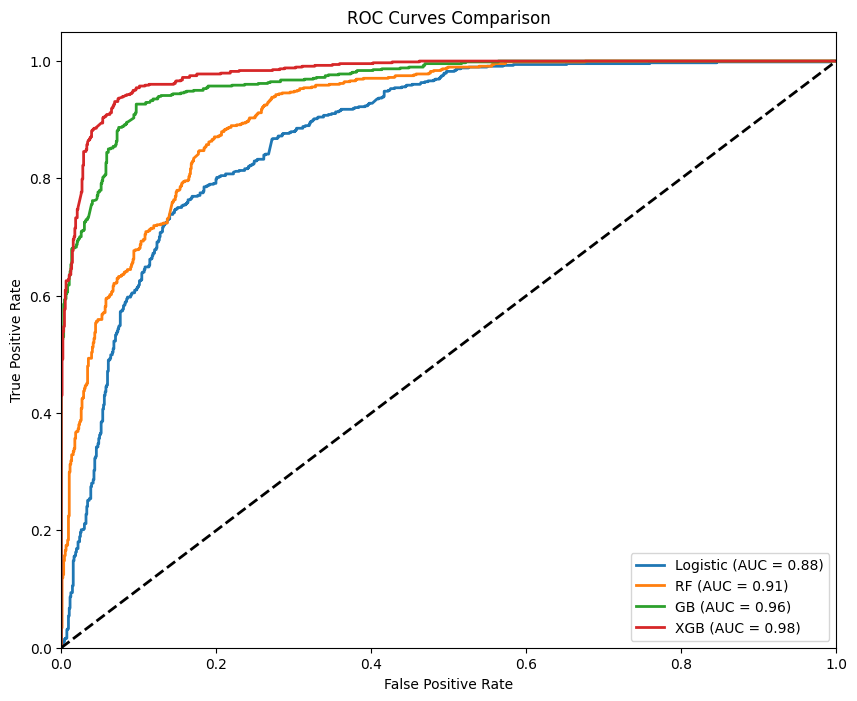

In [115]:
plt.figure(figsize=(10, 8))
for name, results in {
    'Logistic': lr_results,
    'RF': rf_results,
    'GB': gb_results,
    'XGB': xgb_results,
}.items():
    fpr, tpr, _ = roc_curve(y_test, results['model'].predict_proba(X_test_scaled)[:,1])
    roc_auc = auc(fpr, tpr)
    plt.plot(fpr, tpr, lw=2, label=f'{name} (AUC = {roc_auc:.2f})')
plt.plot([0, 1], [0, 1], 'k--', lw=2)
plt.xlim([0.0, 1.0])
plt.ylim([0.0, 1.05])
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
plt.title('ROC Curves Comparison')
plt.legend(loc="lower right")
plt.show()

In [116]:
summary = pd.DataFrame({
    'Model': ['Logistic', 'Random Forest', 'Gradient Boosting', 'XGBoost'],
    'ROC AUC': [lr_results['roc_auc'], 
                rf_results['roc_auc'], 
                gb_results['roc_auc'], 
                xgb_results['roc_auc']],
    'Precision_0': [
        float(lr_results['report'].split()[5]),  
        float(rf_results['report'].split()[5]),
        float(gb_results['report'].split()[5]),
        float(xgb_results['report'].split()[5])
    ],
    'Recall_0': [
        float(lr_results['report'].split()[6]),  
        float(rf_results['report'].split()[6]),
        float(gb_results['report'].split()[6]),
        float(xgb_results['report'].split()[6])
    ],
    'F1_0': [
        float(lr_results['report'].split()[7]),  
        float(rf_results['report'].split()[7]),
        float(gb_results['report'].split()[7]),
        float(xgb_results['report'].split()[7])
    ],
    'Precision_1': [
        float(lr_results['report'].split()[10]),  
        float(rf_results['report'].split()[10]),
        float(gb_results['report'].split()[10]),
        float(xgb_results['report'].split()[10])
    ],
    'Recall_1': [
        float(lr_results['report'].split()[11]),  
        float(rf_results['report'].split()[11]),
        float(gb_results['report'].split()[11]),
        float(xgb_results['report'].split()[11])
    ],
    'F1_1': [
        float(lr_results['report'].split()[12]),  
        float(rf_results['report'].split()[12]),
        float(gb_results['report'].split()[12]),
        float(xgb_results['report'].split()[12])
    ]
})

print("\nModel Comparison (Class 0 and Class 1 Metrics):")
summary.sort_values(by='ROC AUC', ascending=False)


Model Comparison (Class 0 and Class 1 Metrics):


,Model,ROC AUC,Precision_0,Recall_0,F1_0,Precision_1,Recall_1,F1_1
3,XGBoost,0.978548,0.97,0.89,0.93,0.86,0.96,0.91
2,Gradient Boosting,0.964925,0.93,0.91,0.92,0.87,0.90,0.89
1,Random Forest,0.912017,0.94,0.73,0.82,0.71,0.93,0.81
0,Logistic,0.876605,0.85,0.78,0.81,0.72,0.81,0.76


# <span style="color:green">XGBoost Is The Best Model For The Data</span>